# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Посмотроим модель с максимально большим значением `accuracy` и доведем долю правильных ответов по крайней мере до 0.75, а также проверим `accuracy` на тестовой выборке.

# Содержание проекта

- [Импорт файла с выборкой и его изучение](#Импорт_файла_с_выборкой_и_его_изучение)
- [Создание выборки](#Создание_выборки)
- [Исследование моделей](#Исследование_моделей)
- [Проверка модели на тестовой выборке](#Проверка_модели_на_тестовой_выборке)

## Импорт файла с выборкой и его изучение <a name="Импорт_файла_с_выборкой_и_его_изучение"></a>

Загрузим файл в датафрейм, посмотрим его размерность и выведем несколько строк для наглядности данных.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('/datasets/users_behavior.csv')

display(df.shape)
display(df.sample(5))

(3214, 5)

,calls,minutes,messages,mb_used,is_ultra
2715,82.0,595.63,42.0,11437.75,0
2411,73.0,453.90,57.0,4719.69,1
144,53.0,340.04,38.0,15779.55,0
419,91.0,686.38,62.0,20499.92,0
3010,66.0,522.07,13.0,21978.09,0


В нашем распоряжении порядка 3k записей, каждый объект в наборе данных — информация о поведении одного пользователя за месяц. 
Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим, как распределены клиенты по параметрам тарифов. Для этого выведим информацию на гистограмму и тепловую карту с помощью функции `corr()`. 

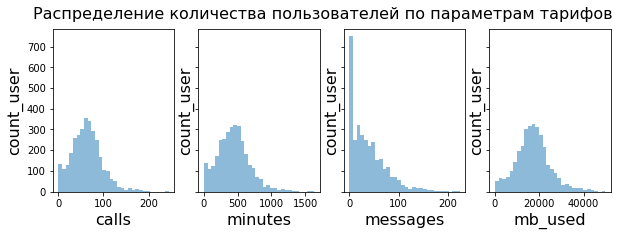

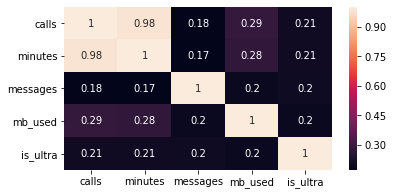

In [2]:
def corr():
    list = ['calls', 'minutes', 'messages', 'mb_used']
    fig, axs = plt.subplots(1, len(list), figsize=(10, 3), sharey=True)
    fig.suptitle('Распределение количества пользователей по параметрам тарифов', fontsize=16)
    for i in list:
        axs[list.index(i)].hist(df[i], bins = 30, alpha = 0.5)
        axs[list.index(i)].set_ylabel('count_user', fontsize=16)
        axs[list.index(i)].set_xlabel(i, fontsize=16)

    fig, ax = plt.subplots(figsize=(6,3))
    sns.heatmap(df.corr(), annot=True)
    plt.show()    

corr()

Как же распределены данные? Видно, что у некоторых пользователей количество минут разговара превышает 1000 минут (более 16 часов) в месяц. Количество звонков превышает более 120 в месяц - это, на мой взгляд, аномалия. Так же есть выброс у пользователей в диапазоне от 0 до 7 сообщений, а некоторые наоборот - отправляют более 150 смс в месяц. При этом трафик более 40 gb выглядит подозрительно. Перед дальнейшим проведением работ избавимся от выбросов. 

Кроме того видно, что длительность звонков (`minutes`) и количествоо звонков (`calls`) сильно коррелируют. Эти признаки равнозначны и показывают одни и те же зависимости. Поэтому для упрощения работы модели можно с чистой совестью избавиться от одного из них (например, от `minutes` - его дольше печатать)

In [3]:
df = df.query('minutes <= 1000 and calls <= 120 and 7 <= messages <= 150 and mb_used <= 40000').drop(['minutes'], axis = 1)

display(df.sample(3))

,calls,messages,mb_used,is_ultra
1709,41.0,24.0,15252.74,0
743,88.0,80.0,8983.42,0
1444,88.0,19.0,20677.89,0


## Создание выборки<a name="Создание_выборки"></a>

Данные нужно разбить на три части: `обучающую` (60%), `валидационную` (20%) и `тестовую` (20%). В каждой выборке выделим переменные для признаков (`features`) и целевого признака - тарифа (`target`).

In [4]:
df_train, df_valid_test = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)


feature_train = df_train.drop(columns = ['is_ultra'], axis = 1)
target_train = df_train.is_ultra

feature_valid = df_valid.drop(columns = ['is_ultra'], axis = 1)
target_valid = df_valid.is_ultra

feature_test = df_test.drop(columns = ['is_ultra'], axis = 1)
target_test = df_test.is_ultra


for i in (df_train, df_valid, df_test):
    display('size = %s, perc = %s' % (i.shape[0], round(i.shape[0] / df.shape[0] *100, 2)))

'size = 1400, perc = 59.98'

'size = 467, perc = 20.01'

'size = 467, perc = 20.01'

## Исследуйте модели

Применим несколько моделей обучения: дерево решений, случайный лес и линейную регрессию.

###  Дерево решений <a name="Дерево_решений"></a>

Используем структуру дерево решений. Создадим объект структуры данных (model), обучим ее методом `fit()`, предсткажем тариф, который будет выбран клиентами.
Чтобы получить максимальное качество модели, посмотрим разную глубину `depth` дерева. Настраивать разные варианты глубины дерева будем на тренировочном наборе.

In [5]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # инициализируем модель 
    model.fit(feature_train, target_train) # обучаем модель на тренировочной выборке
    predictions_valid = model.predict(feature_valid)  # получаем предсказания модели на валидационной выборке
    result = accuracy_score(predictions_valid, target_valid)  # смотрим долю правильных ответов
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
display("accuracy наилучшей модели на валидационной выборке: %s, глубина дерева: %s" % 
                (best_result, best_depth))        

'accuracy наилучшей модели на валидационной выборке: 0.8244111349036403, глубина дерева: 5'

### Случайный лес <a name="Случайный_лес"></a>
Обучим модель случайного леса с количеством деревьев от 10 до 50 с шагом 10 и с максимальной глубиной от 1 до 10. Для каждой модели посчитаем RSME и посмотрим на лучший результат.

In [6]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth) 
        model.fit(feature_train, target_train) 
        predictions_valid = model.predict(feature_valid) 
        result = accuracy_score(predictions_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
display("accuracy наилучшей модели на валидационной выборке: %s, количество деревьев: %s, максимальная глубина: %s" % 
                (best_result, best_est, depth))  

'accuracy наилучшей модели на валидационной выборке: 0.8436830835117773, количество деревьев: 20, максимальная глубина: 10'

###  Логистическая регрессия <a name="Логистическая_регрессия"></a>

Обучим модель логистической регрессии.

In [7]:
model = LogisticRegression(random_state = 12345) 
model.fit(feature_train, target_train) 
result = model.score(feature_valid, target_valid)
display("accuracy модели линейной регрессии на валидационной выборке: %s" % result)

'accuracy модели линейной регрессии на валидационной выборке: 0.7794432548179872'

`Итог по моделям следующий:`

- **дерево решений**: accuracy наилучшей модели на валидационной выборке: 0.8244111349036403, глубина дерева: 5. 
Высокая скорость работы, всего за пять проверок модель получила ответ на вопрос, а это очень быстро. Вторая по размеру метрики accuracy

- **случайный лес**: accuracy наилучшей модели на валидационной выборке: 0.8436830835117773, количество деревьев: 20, максимальная глубина: 10. 
Данная модель медленее всех (еще бы - 20 деревьев!), но показывает самое высокое качество -  вместо одного решающего дерева, используется целый ансамбль;

- **линейная регрессия**: accuracy модели линейной регрессии на валидационной выборке: 0.7794432548179872. 
У данной модели самая высокая скорость работы из-за мЕньшего количества параметров (выполнение модели порядка 0.1s), и самое низкое качество модели (доля правильных ответов).


## Проверьте модель на тестовой выборке

Проверим самую лучшую модель по итогам прошлого пункта (`случайный лес`) на тестовой выборке. Соединим перед этим тренировочные и валидационные выборки. Обучаем модель на тренировочной выборке, делаем предсказание на тесте.

In [8]:
feature_train_new = pd.concat([feature_train, feature_valid])
target_train_new = pd.concat([target_train, target_valid])

model = RandomForestClassifier(random_state = 12345, n_estimators = 20, max_depth = 10) 
model.fit(feature_train_new, target_train_new) 

predictions_train = model.predict(feature_train_new) 
accuracy_train = accuracy_score(target_train_new, predictions_train)

predictions_test = model.predict(feature_test) 
accuracy_test = accuracy_score(target_test, predictions_test)

display("accuracy модели случайный лес на обучающей выборке - %s, на тестовой - %s" % (accuracy_train, accuracy_test))

'accuracy модели случайный лес на обучающей выборке - 0.90037493304767, на тестовой - 0.8222698072805139'

Как итог - удалось добиться значения метрики accuracy не меньше 0.75

## (бонус) Проверьте модели на адекватность

Для проверки модели на ее вменяемость необходимо посмотреть метрику `DummyClassifier` `most_frequent` - всегда предсказывает наиболее часто встречающуюся метку в обучающем наборе.

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [10]:
clf = DummyClassifier(strategy='most_frequent', random_state=12345) # смотрим самое встречающееся значение
clf.fit(feature_train_new, target_train_new)                        # обучаем ее еа еашей тренировочной выборке
result = clf.score(feature_test, target_test)                       # смиотрим долю правильных ответов
display(result)

0.7259100642398287

Качество нашей модели (**0.822**) получилось выше наивной (**0.726**) - считаем это успехом!